In [10]:
import pandas as pd
import numpy as np

filename = 'labeledPackets.csv'


# make a array, li, to hold both initial data frames from the CSV files
li = []
li.append(pd.read_csv(filename))


data = pd.concat(li, axis=0,ignore_index=True)

In [13]:
# preprocess the data
#import ipaddress

# loop through all indexes to preprocessdata
for index in range(len(data)):
  #print(index,row['SourceIP'],row['DestinationIP'])
  #data.at[index,'SourceIP'] = int(ipaddress.IPv4Address(data.loc[index,'SourceIP']))
  #data.at[index,'DestinationIP'] = int(ipaddress.IPv4Address(data.loc[index,'DestinationIP']))

  # clean up responsetimetimemedian and responsetimetimeskewfrommedian NaN values
  if np.isnan(data.loc[index,'ResponseTimeTimeMedian']):
     data.at[index,'ResponseTimeTimeMedian'] = 0
  if np.isnan(data.loc[index,'ResponseTimeTimeSkewFromMedian']):
     data.at[index,'ResponseTimeTimeSkewFromMedian'] = 0

# drop unwanted columns
data = data.drop(['TimeStamp','SourceIP','DestinationIP','SourcePort','DestinationPort'],axis=1)

# verify; check for nans left
for col in data.columns:
      NaNsum = data.loc[:,col].isna().sum()
      if NaNsum > 0:
        print("Col: %s NaN: %d" % (col,NaNsum)
              
row_count = data.shape[0]
print
#data.tail()



SyntaxError: invalid syntax (1000404238.py, line 25)

In [3]:
# get the data ready to be put into the decision tree/Naive Bayes/SVM
from sklearn.model_selection import train_test_split

# training data
cdata = data.drop('Label', axis=1)
labels = data['Label']

# preprocess

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

#scaler = StandardScaler()
#scaler.fit(cdata)
#cdata = scaler.transform(cdata)

#columnTransformer = ColumnTransformer([('encoder', OneHotEncoder(), [0])], remainder='passthrough')
#cdata = np.array(columnTransformer.fit_transform(cdata), dtype = np.str)

#cdata

# split things up 80%/20%
cdata_train, cdata_test, labels_train, labels_test = train_test_split(cdata,labels, test_size=0.2, random_state=1)

# check nans
#cdata_train = cdata_train.fillna(cdata_train.mean())


In [4]:
from sklearn import tree
# make the decision tree - unlimited depth
cls = tree.DecisionTreeClassifier()
cls.fit(cdata_train, labels_train)

# make a second decision tree - max depth 10
clsd10 = tree.DecisionTreeClassifier(max_depth=10)
clsd10.fit(cdata_train, labels_train)

DecisionTreeClassifier(max_depth=10)

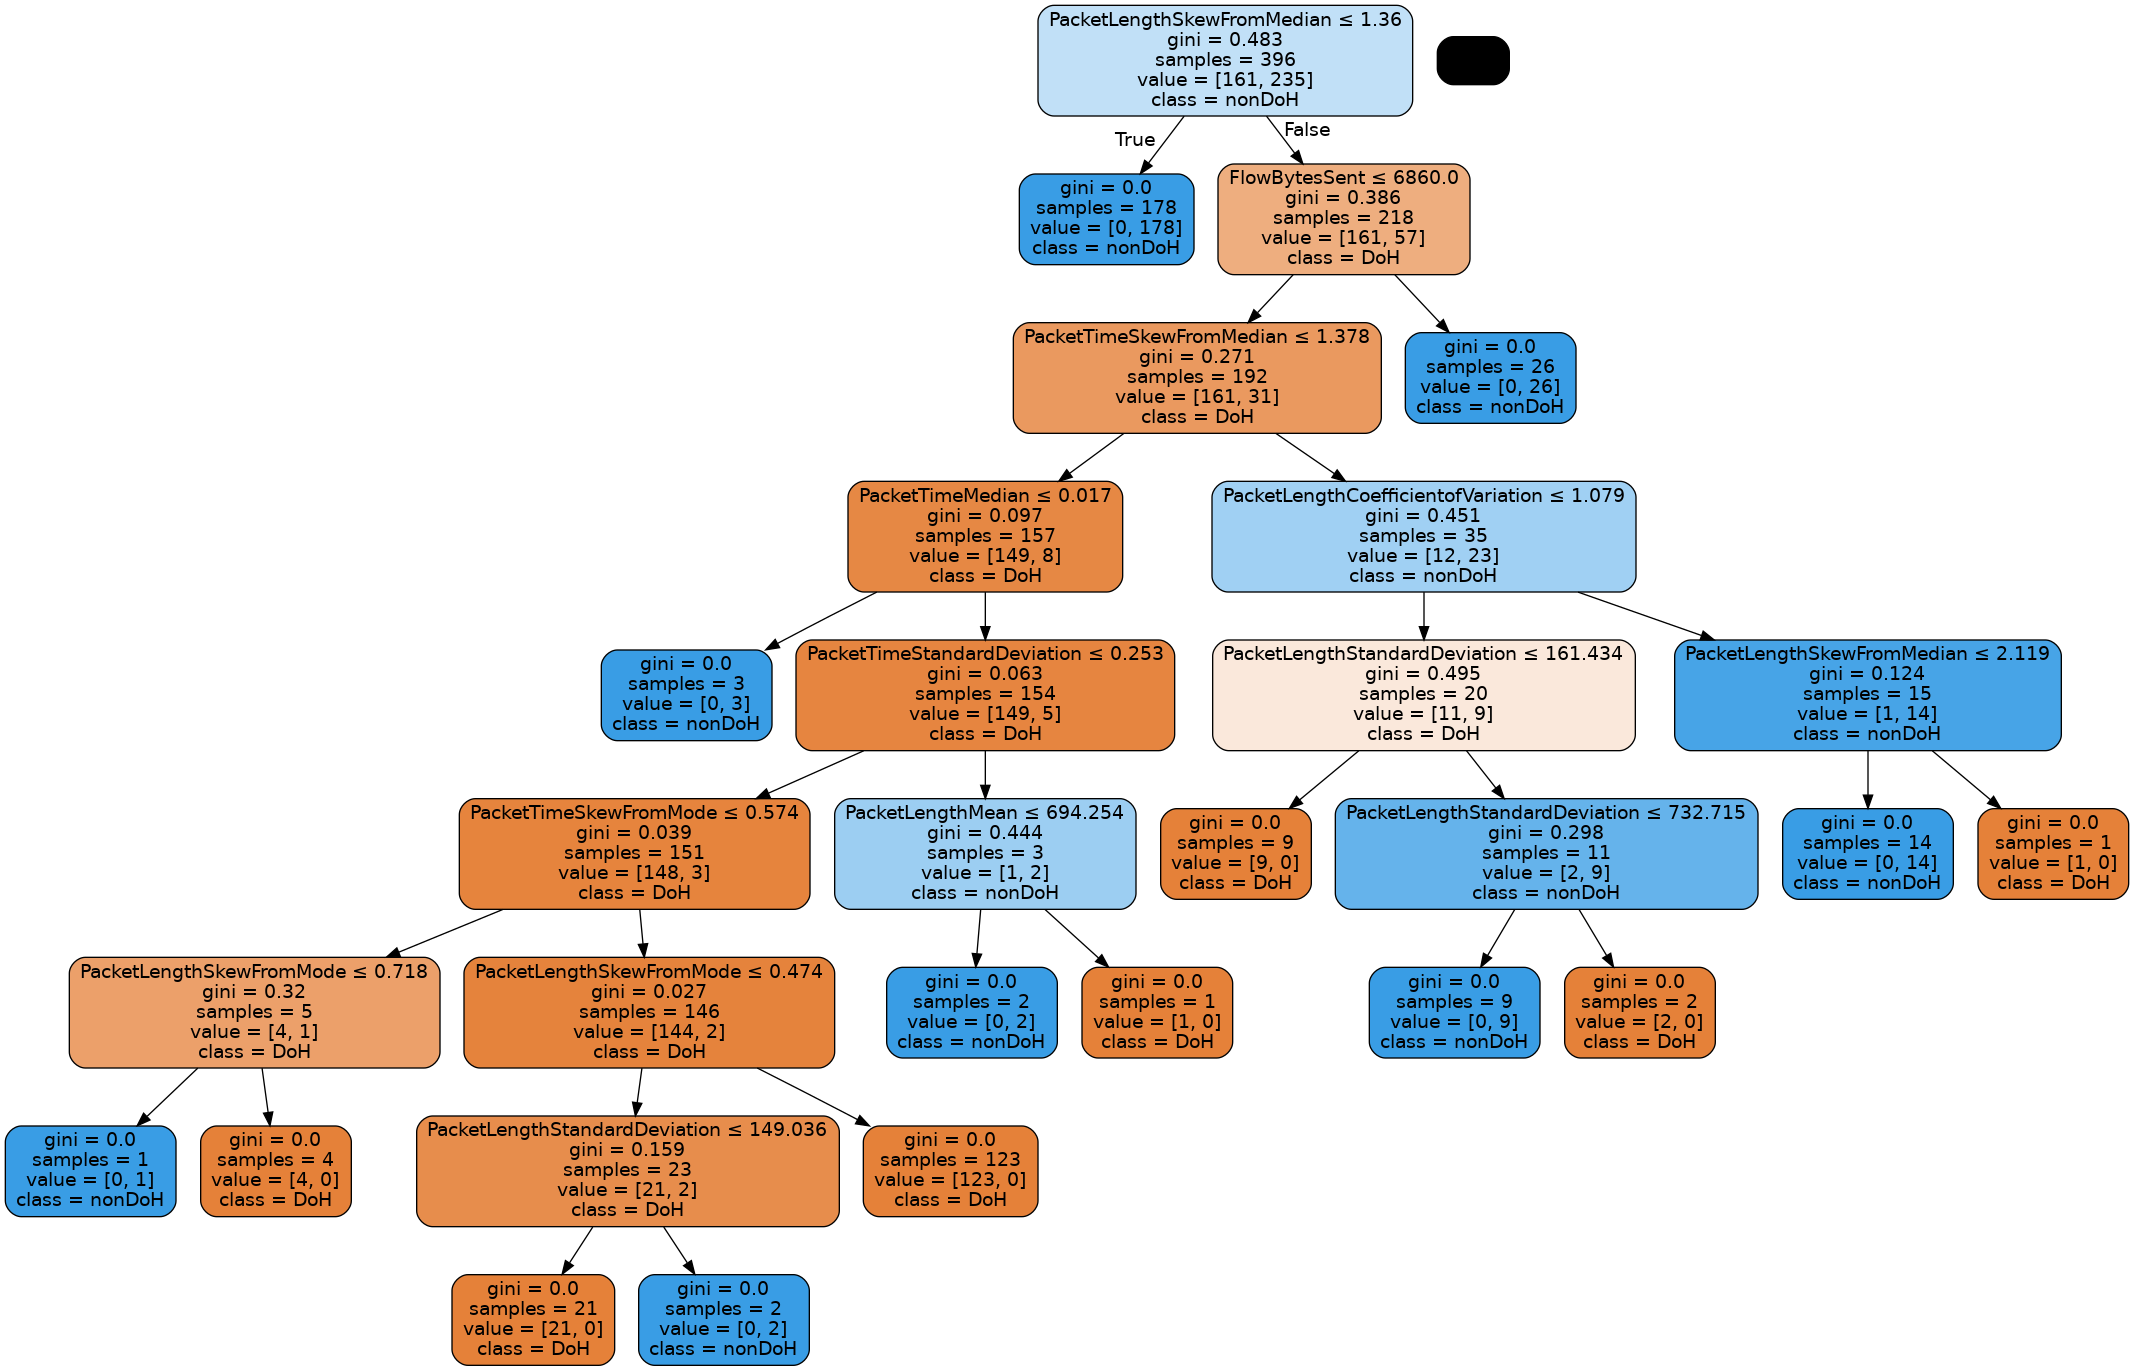

In [5]:
from sklearn.tree import export_graphviz
from io import StringIO
from IPython.display import Image
import pydotplus

# make the first unlimited depth tree
dot_data = StringIO()
export_graphviz(cls, out_file=dot_data, filled=True, rounded=True, special_characters=True, feature_names = cdata.columns, class_names=['DoH','nonDoH'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

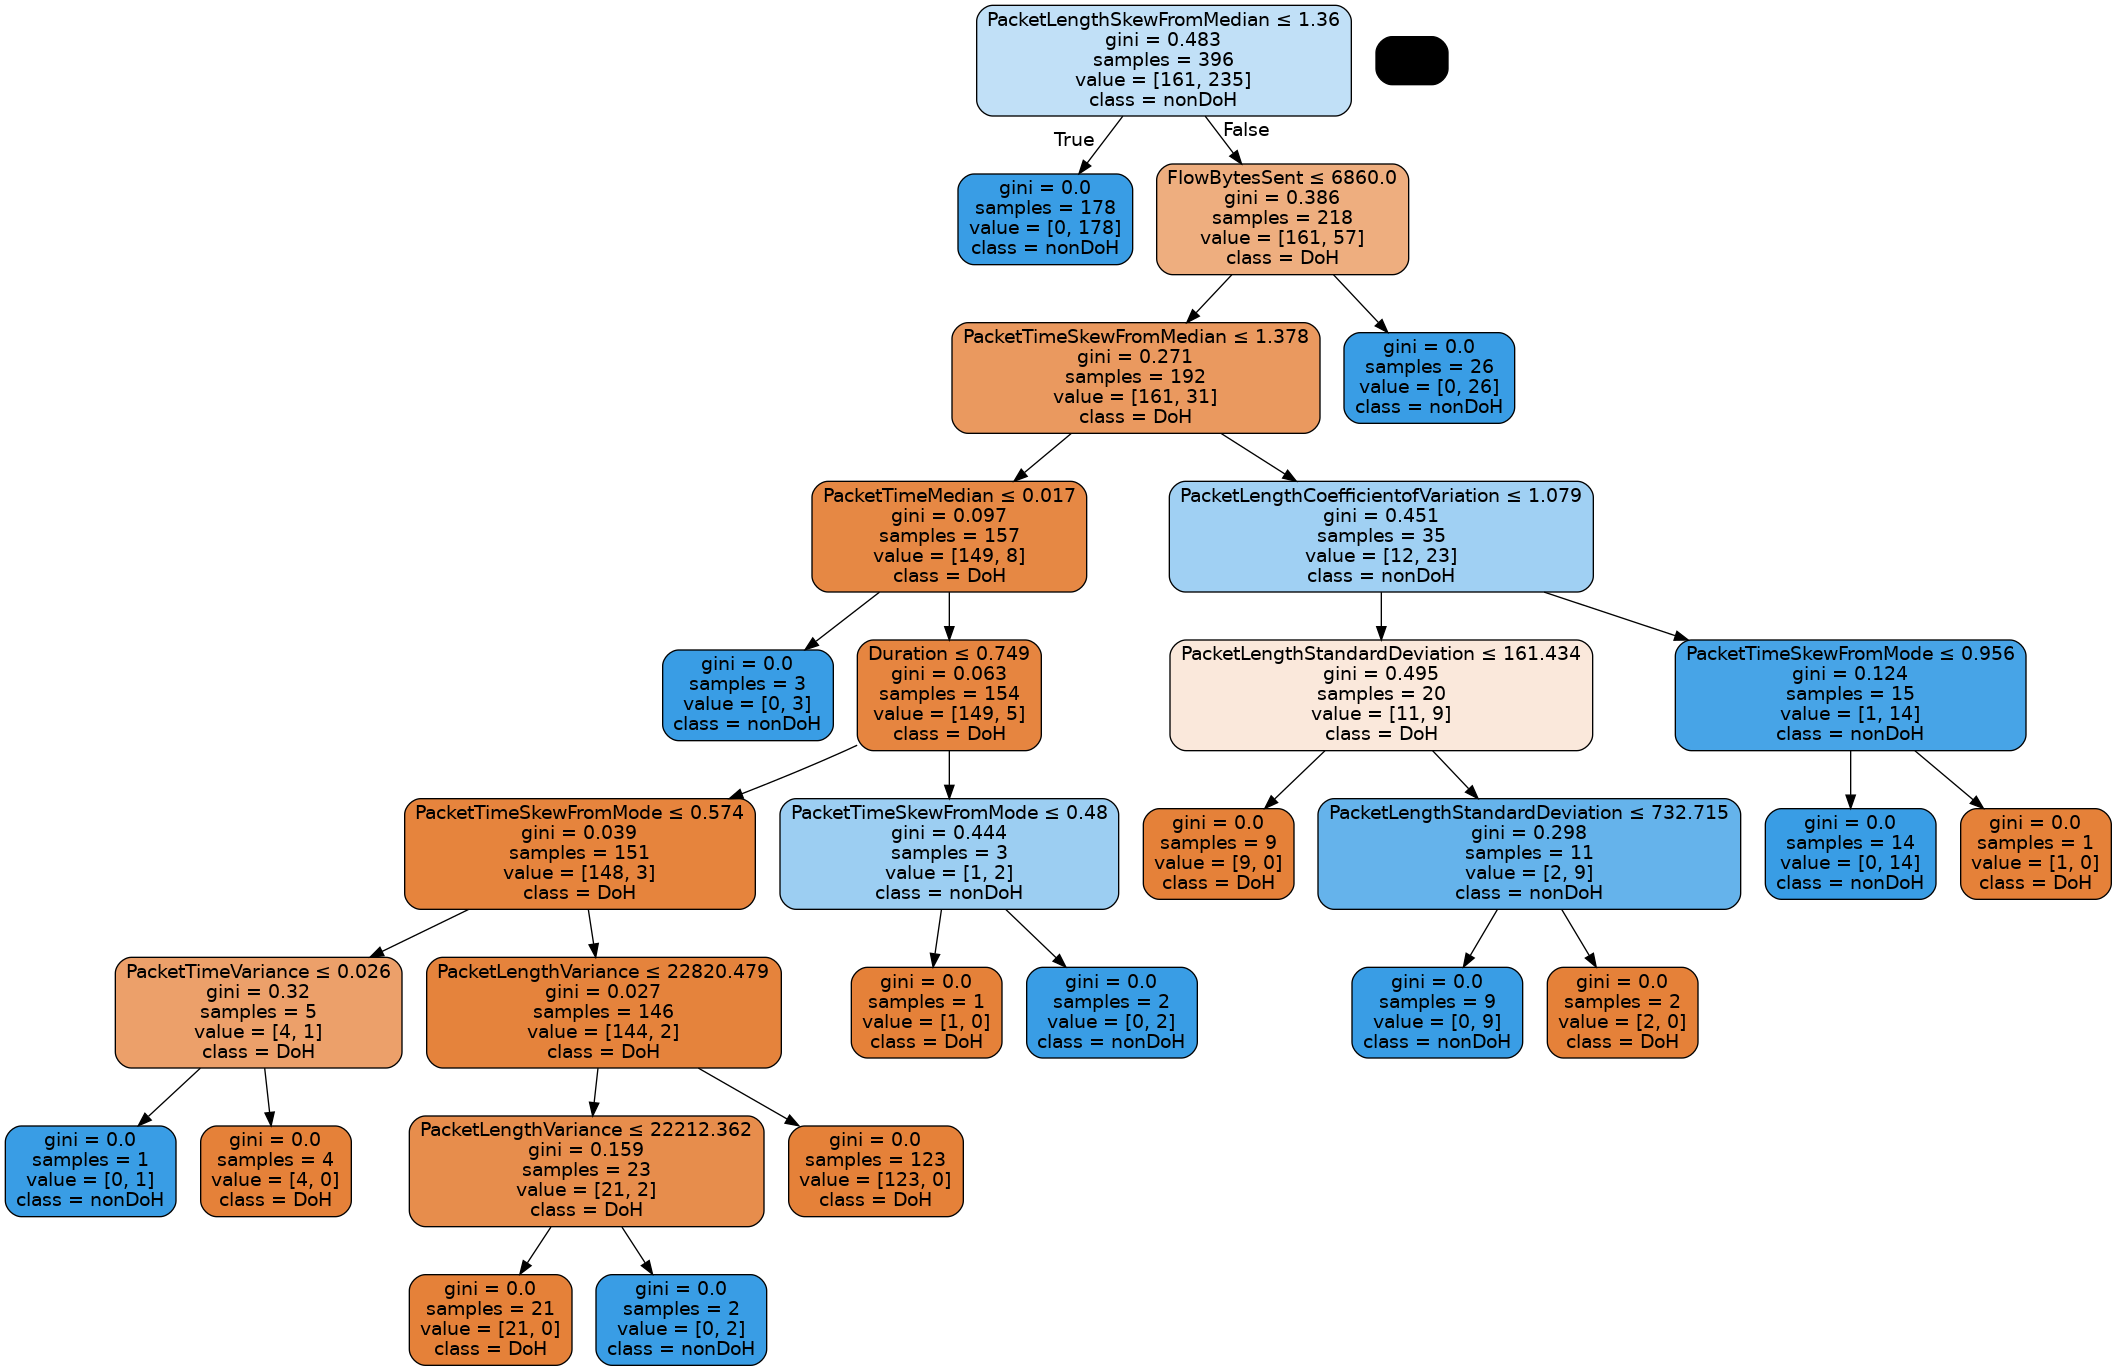

In [6]:
# make the second depth=10 tree
dot_data2 = StringIO()
export_graphviz(clsd10, out_file=dot_data2, filled=True, rounded=True, special_characters=True, feature_names = cdata.columns, class_names=['DoH','nonDoH'])
graph2 = pydotplus.graph_from_dot_data(dot_data2.getvalue())
Image(graph2.create_png())

In [7]:
from sklearn import metrics

# fit the test data
cdata_test_pred = cls.predict(cdata_test)
cdata_test_pred_d10 = clsd10.predict(cdata_test)

# get the confusion matrix and other statistics
tn, fp, fn, tp = metrics.confusion_matrix(labels_test,cdata_test_pred).ravel()
precision = tp/(tp+fp)
recall    = tp/(tp+fn)
f1        = 2*((precision*recall)/(precision+recall))

tnd10, fpd10, fnd10, tpd10 = metrics.confusion_matrix(labels_test,cdata_test_pred_d10).ravel()
precisiond10 = tpd10/(tpd10+fpd10)
recalld10    = tpd10/(tpd10+fnd10)
f1d10        = 2*((precisiond10*recalld10)/(precisiond10+recalld10))

# print out results
print("Decision Tree - Unlimited depth:")
print("    Accuracy:",metrics.accuracy_score(labels_test,cdata_test_pred))
print("    (TN,FP,FN,TP): [%d,%d,%d,%d]" % (tn,fp,fn,tp))
print("    Precision: %f" % precision)
print("    Recall: %f" % recall)
print("    F1 score: %f" % f1)

print("Decision Tree - Depth 10:")
print("    Accuracy:",metrics.accuracy_score(labels_test,cdata_test_pred_d10))
print("    (TN,FP,FN,TP): [%d,%d,%d,%d]" % (tnd10,fpd10,fnd10,tpd10))
print("    Precision: %f" % precisiond10)
print("    Recall: %f" % recalld10)
print("    F1 score: %f " % f1d10)

Decision Tree - Unlimited depth:
    Accuracy: 0.93
    (TN,FP,FN,TP): [36,7,0,57]
    Precision: 0.890625
    Recall: 1.000000
    F1 score: 0.942149
Decision Tree - Depth 10:
    Accuracy: 0.93
    (TN,FP,FN,TP): [36,7,0,57]
    Precision: 0.890625
    Recall: 1.000000
    F1 score: 0.942149 


In [8]:
# # gaussian naive bayes
# from sklearn.naive_bayes import GaussianNB

# gnb = GaussianNB()
# gnb.fit(cdata_train,labels_train)
# cdata_test_pred = gnb.predict(cdata_test)

# # get the confusion matrix and other statistics
# tn, fp, fn, tp = metrics.confusion_matrix(labels_test,cdata_test_pred).ravel()
# precision = tp/(tp+fp)
# recall    = tp/(tp+fn)
# f1        = 2*((precision*recall)/(precision+recall))

# # print out results
# print("Naive Bayes Gaussian:")
# print("    Accuracy:",metrics.accuracy_score(labels_test,cdata_test_pred))
# print("    (TN,FP,FN,TP): [%d,%d,%d,%d]" % (tn,fp,fn,tp))
# print("    Precision: %f" % precision)
# print("    Recall: %f" % recall)
# print("    F1 score: %f" % f1)

In [9]:
# #SVM
# from sklearn import svm
# from sklearn.metrics import confusion_matrix


# #May want to loop through these..
# C = 1e+03
# gamma =1e-04

# clf = svm.SVC(C=C, gamma = gamma, kernel ='rbf', probability = True)
# clf = clf.fit(cdata_train, labels_train)

# labels_pred=clf.predict(cdata_test)

# tn, fp, fn, tp = confusion_matrix(labels_test, labels_pred).ravel()
# precision = tp/(tp+fp)
# recall    = tp/(tp+fn)
# f1        = 2*((precision*recall)/(precision+recall))

# # print out results
# print("SVM: C: %d, gamma: %d" %(C, gamma))
# print("    Accuracy:",metrics.accuracy_score(labels_test,cdata_test_pred))
# print("    (TN,FP,FN,TP): [%d,%d,%d,%d]" % (tn,fp,fn,tp))
# print("    Precision: %f" % precision)
# print("    Recall: %f" % recall)
# print("    F1 score: %f" % f1)


# #tn, fp, fn, tp, precision, recall, f1
